*This notebook was prepared for the life science workshop at the 2021 Dask Summit.
It is an interactive version of the post https://napari.org/tutorials/applications/dask.html
(deconvolution has been removed for ease of environment setup)*


## napari: an n-dimensional data viewer for python
----

<a href="https://napari.org"><img src="https://napari.org/_static/logo.ico" alt="napari" style="height: 120px; float: left; padding-right:25px;"/></a>

napari is a python-based n-dimensional data viewer backed by **vispy** ([vispy.org](https://vispy.org/) - for OpenGL rendering), and Qt (for GUI). It supports a variety of array formats (**numpy, dask, zarr, xarray**, etc...).

For a more in depth introduction to napari, please start at  [napari.org](https://napari.org)


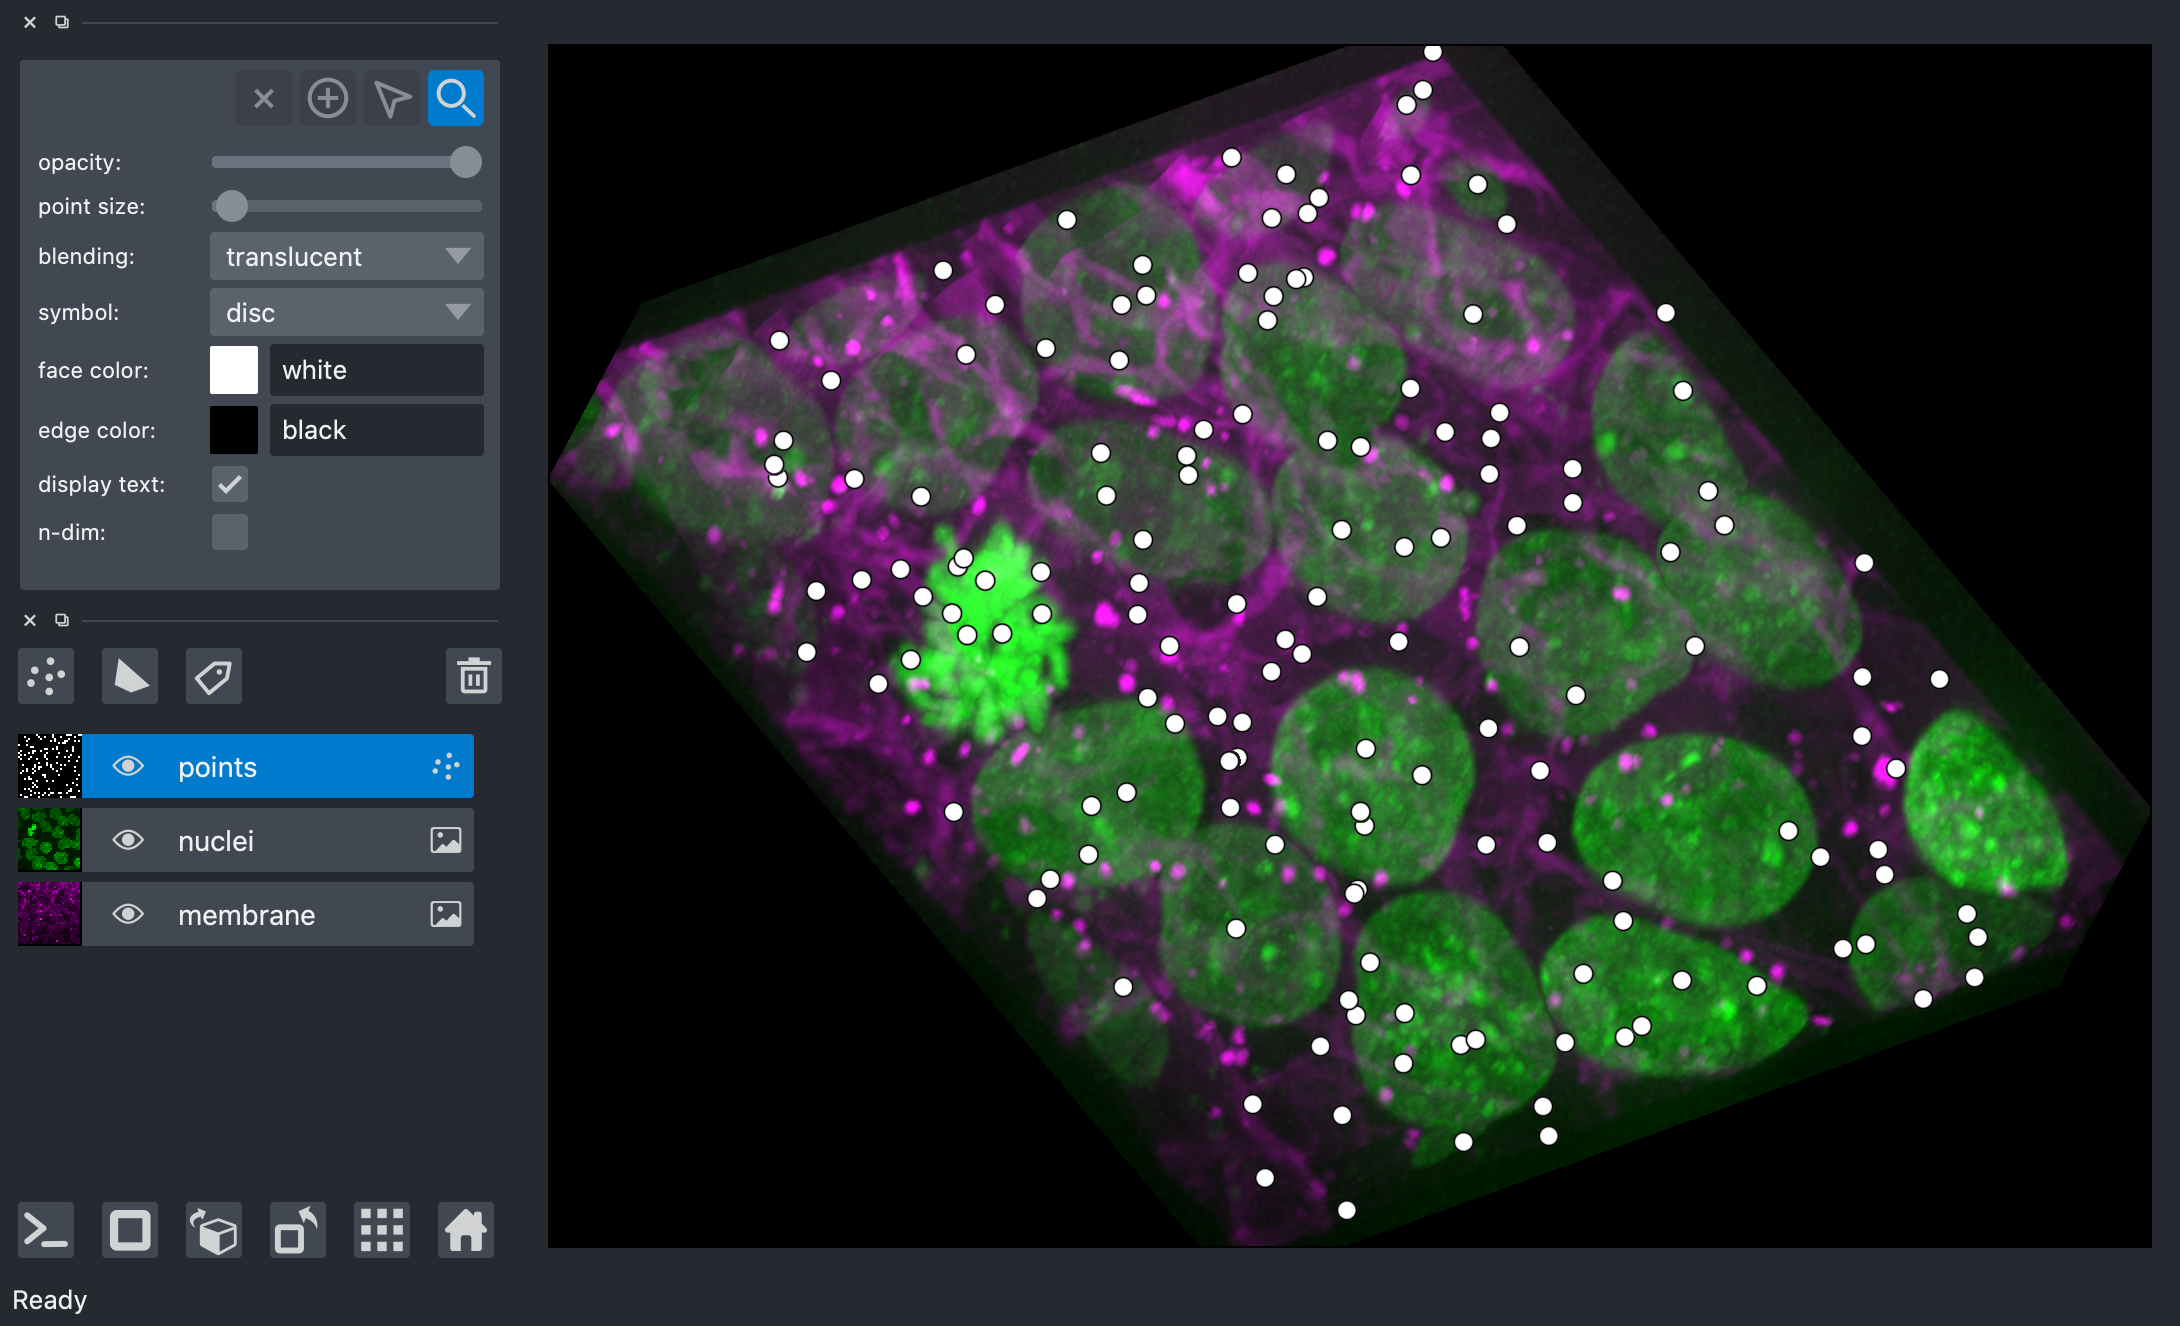

In [1]:
from napari import Viewer, utils
import numpy as np
from skimage.data import cells3d

# napari.Viewer is the main object
viewer = Viewer()

# open some sample data
layers = viewer.add_image(
    cells3d(),
    name= ['membrane', 'nuclei'],
    contrast_limits=[(1110, 30000), (1600, 50000)],
    channel_axis=1
)

# add various "layer" types (like points here)
points = np.random.rand(150, 3) * layers[0].data.shape
viewer.add_points(points, size=3)

# programmatically control viewer state 
viewer.dims.ndisplay=3
viewer.camera.angles = (20, -40, 120)

# add screenshot to ipython notebook
utils.nbscreenshot(viewer)

## napari supports dask arrays

<img src="https://napari.org/_static/logo.ico" alt="napari" style="height: 75px; display: inline; padding-right:30px; padding-top: 10px;"/><img src="https://upload.wikimedia.org/wikipedia/commons/f/f1/Heart_coraz%C3%B3n.svg" style="display: inline; height: 60px; padding-bottom: 10px;"><img src="https://docs.dask.org/en/latest/_images/dask_horizontal.svg" style="height: 90px; display: inline;">

Dask makes it possible for napari to scale to out-of-core images and datasets, with hardly any modification of our internal code.

If the user provides a (properly chunked) dask array, napari will compute the minimum amount of data required to view the currently requested indices.

In [2]:
from dask import array as da
from napari import view_image

# make a giant multidimensional dask array
massive_array = da.random.random((8, 64, 128, 1024, 1024), chunks=(1, 1, 1, 1024, 1024))
massive_array

dask.array<random_sample, shape=(8, 64, 128, 1024, 1024), dtype=float64, chunksize=(1, 1, 1, 1024, 1024), chunktype=numpy.ndarray>

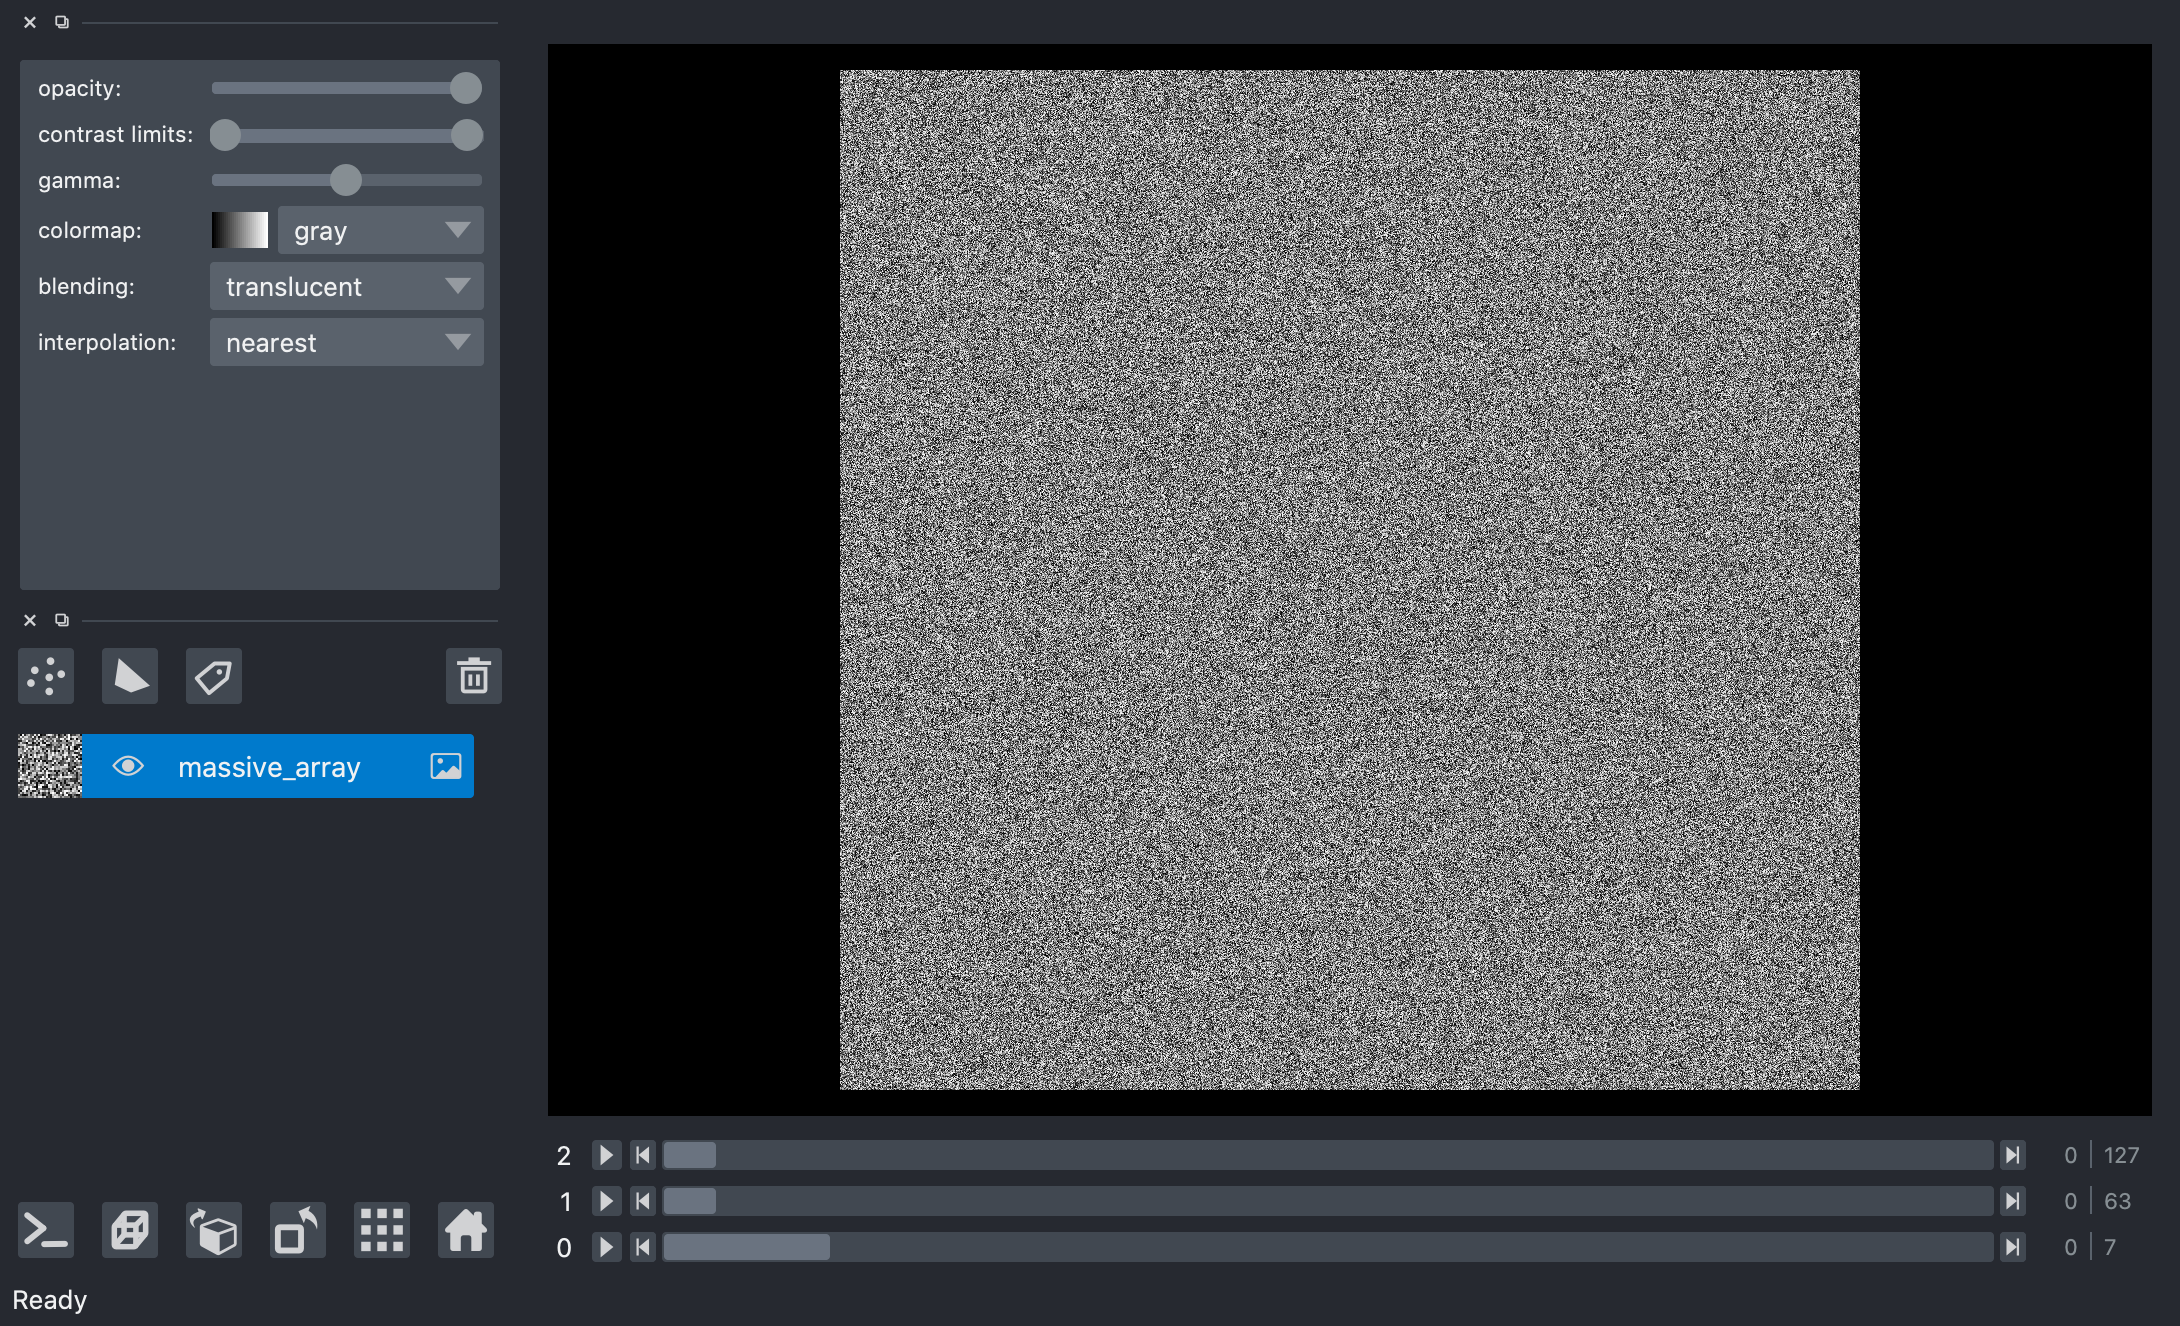

In [3]:
# have a look... each 1024x1024 plane is loaded on demand.
viewer = view_image(massive_array, title='lots of data!')
utils.nbscreenshot(viewer)

## make any `() -> array` function lazy with `dask.delayed`

Very large image datasets often don't fit into local ram, so we need a way to load images only upon request...

By using [`dask.delayed`](https://docs.dask.org/en/latest/delayed.html) we can convert any function that returns an array (novel file readers, costly data generators, etc...) into a "lazy" data loader for napari.  Napari can then call [`.compute()`](https://distributed.dask.org/en/latest/manage-computation.html#dask-collections-to-concrete-values) only on the necessary frames depending on how the user interacts with the dimensions sliders:

Let's wrap `tifffile.imread` to load some sample data.  

A small subset of this dataset has been included in this repo, but a larger version (~11GB) of the same dataset available at: https://www.ebi.ac.uk/biostudies/studies/S-BSST435).


_Note_: the concepts in the following cell are covered in much greater detail in the blog post
[Load Large Image Data with Dask Array](https://blog.dask.org/2019/06/20/load-image-data)
by John Kirkham.


In [4]:
from tifffile import imread
from pathlib import Path
from dask import delayed

# create delayed version of our path -> np.array function
lazy_imread = delayed(imread)

# get a list of all tiff files in the directory
data_dir = Path('lls_mitosis')
filenames = sorted(data_dir.glob("*.tif"))

# peek into the first file to get shape
first_image = imread(filenames[0])
shape = first_image.shape
dtype = first_image.dtype

# create dask arrays from the Delayed objects returned from our lazy_imread function
dask_arrays = (da.from_delayed(lazy_imread(fn), shape=shape, dtype=dtype) for fn in filenames)

# stack them into a dask.array
stack = da.stack(dask_arrays)
stack

dask.array<stack, shape=(20, 65, 184, 157), dtype=uint16, chunksize=(1, 65, 184, 157), chunktype=numpy.ndarray>

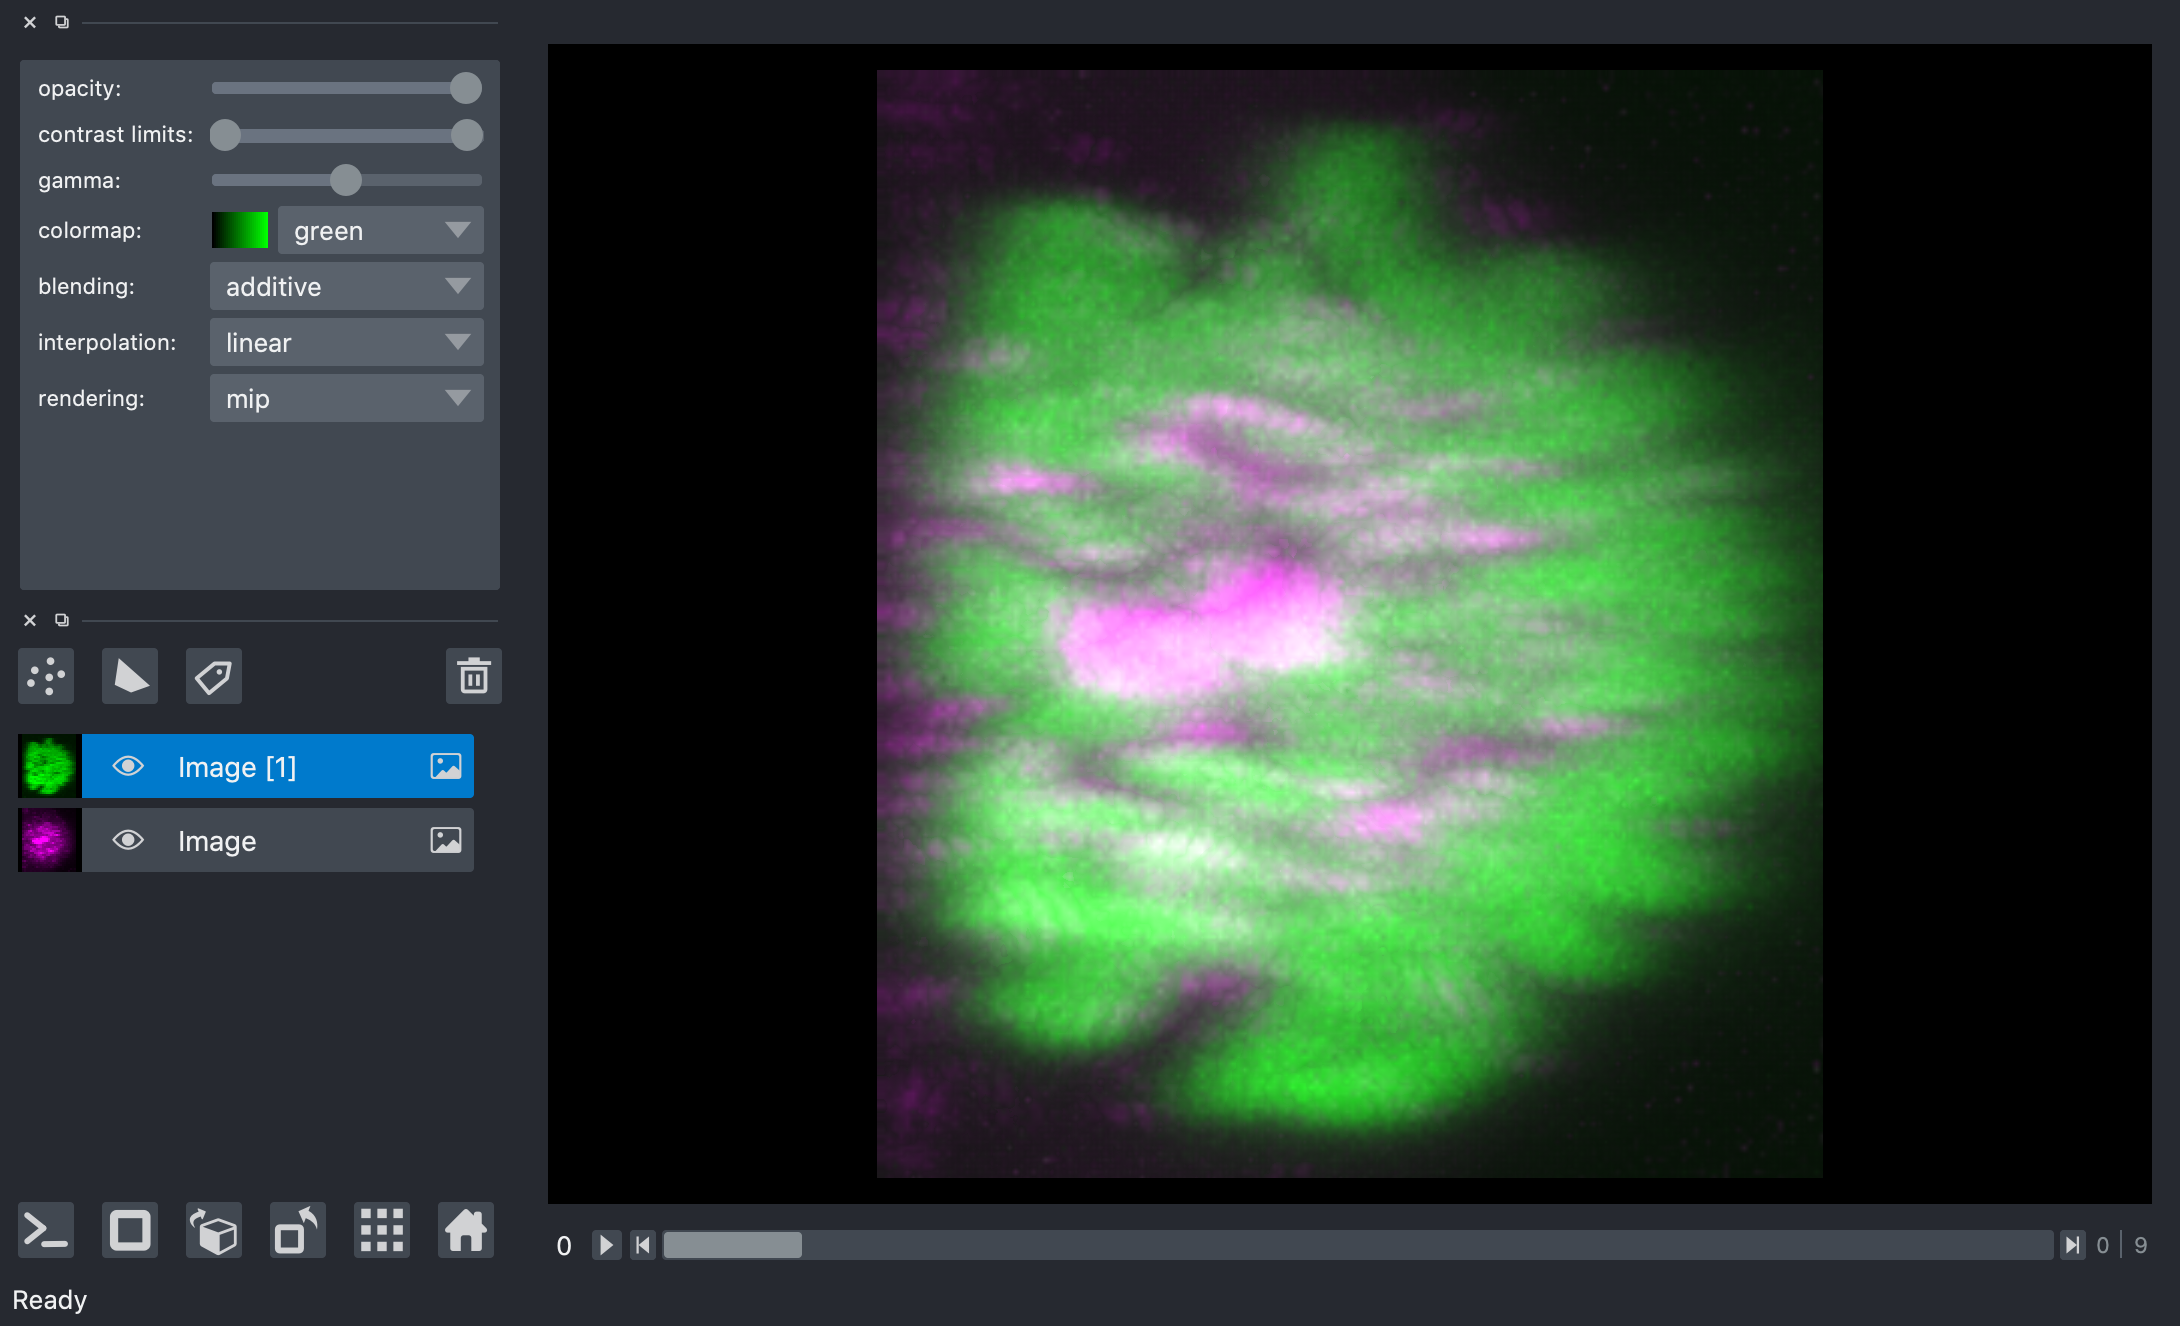

In [5]:
# napari works with dask arrays
viewer = view_image(stack.reshape(2, -1, *shape), channel_axis=0, title='pre-processed data')
viewer.dims.ndisplay = 3
utils.nbscreenshot(viewer)

## This data requires preprocessing!


#### Domain-specific details: 

The data we're looking at here was collected on a
lattice light sheet microscope [(Chen et al 2014)](https://science.sciencemag.org/content/346/6208/1257998).

In some acquisition modes, the raw 3D data is acquired in a sheared coordinate space (relative to the "real world") and needs preprocessing before viewing.  That's why that image above looks so strange.

See video below for more details if you're curious:

In [6]:
from IPython.display import Video

Video('https://cbmf.hms.harvard.edu/wp-content/uploads/2017/02/deskewing.mp4', width=720)

# lazy processing with `dask.array.map_blocks`

To chain together a sequence of operations (like an affine transformation followed by deconvolution) on our delayed stack, we can use [`dask.array.map_blocks`](https://docs.dask.org/en/latest/array-api.html#dask.array.map_blocks). Nothing is actually computed until the data is requested in the napari viewer.


_Note_: the concepts in the following cell are covered in much greater detail in the blog post
[Dask and ITK for large scale image analysis](https://blog.dask.org/2019/08/09/image-itk)
by John Kirkham, Matthew Rocklin, & Matthew McCormick



In [7]:
# napari_ndtiffs.affine provides a fast OpenCL-backed affine transform
# but falls back to scipy if pyopencl is unavailable.
from napari_ndtiffs.affine import get_deskew_func

deskew, new_shape, dzdx_ratio = get_deskew_func(stack.shape, dz=0.5, dx=0.1, angle=31.5)
print(f"shape will change from {stack.shape} -> {new_shape}" )

# Map our "deskew" function across all blocks of the original stack.
deskewed = stack.map_blocks(deskew, dtype="float32", chunks=new_shape)
deskewed

shape will change from (20, 65, 184, 157) -> [1, 65, 184, 429]


dask.array<noisy_deskew, shape=(20, 65, 184, 429), dtype=float32, chunksize=(1, 65, 184, 429), chunktype=numpy.ndarray>

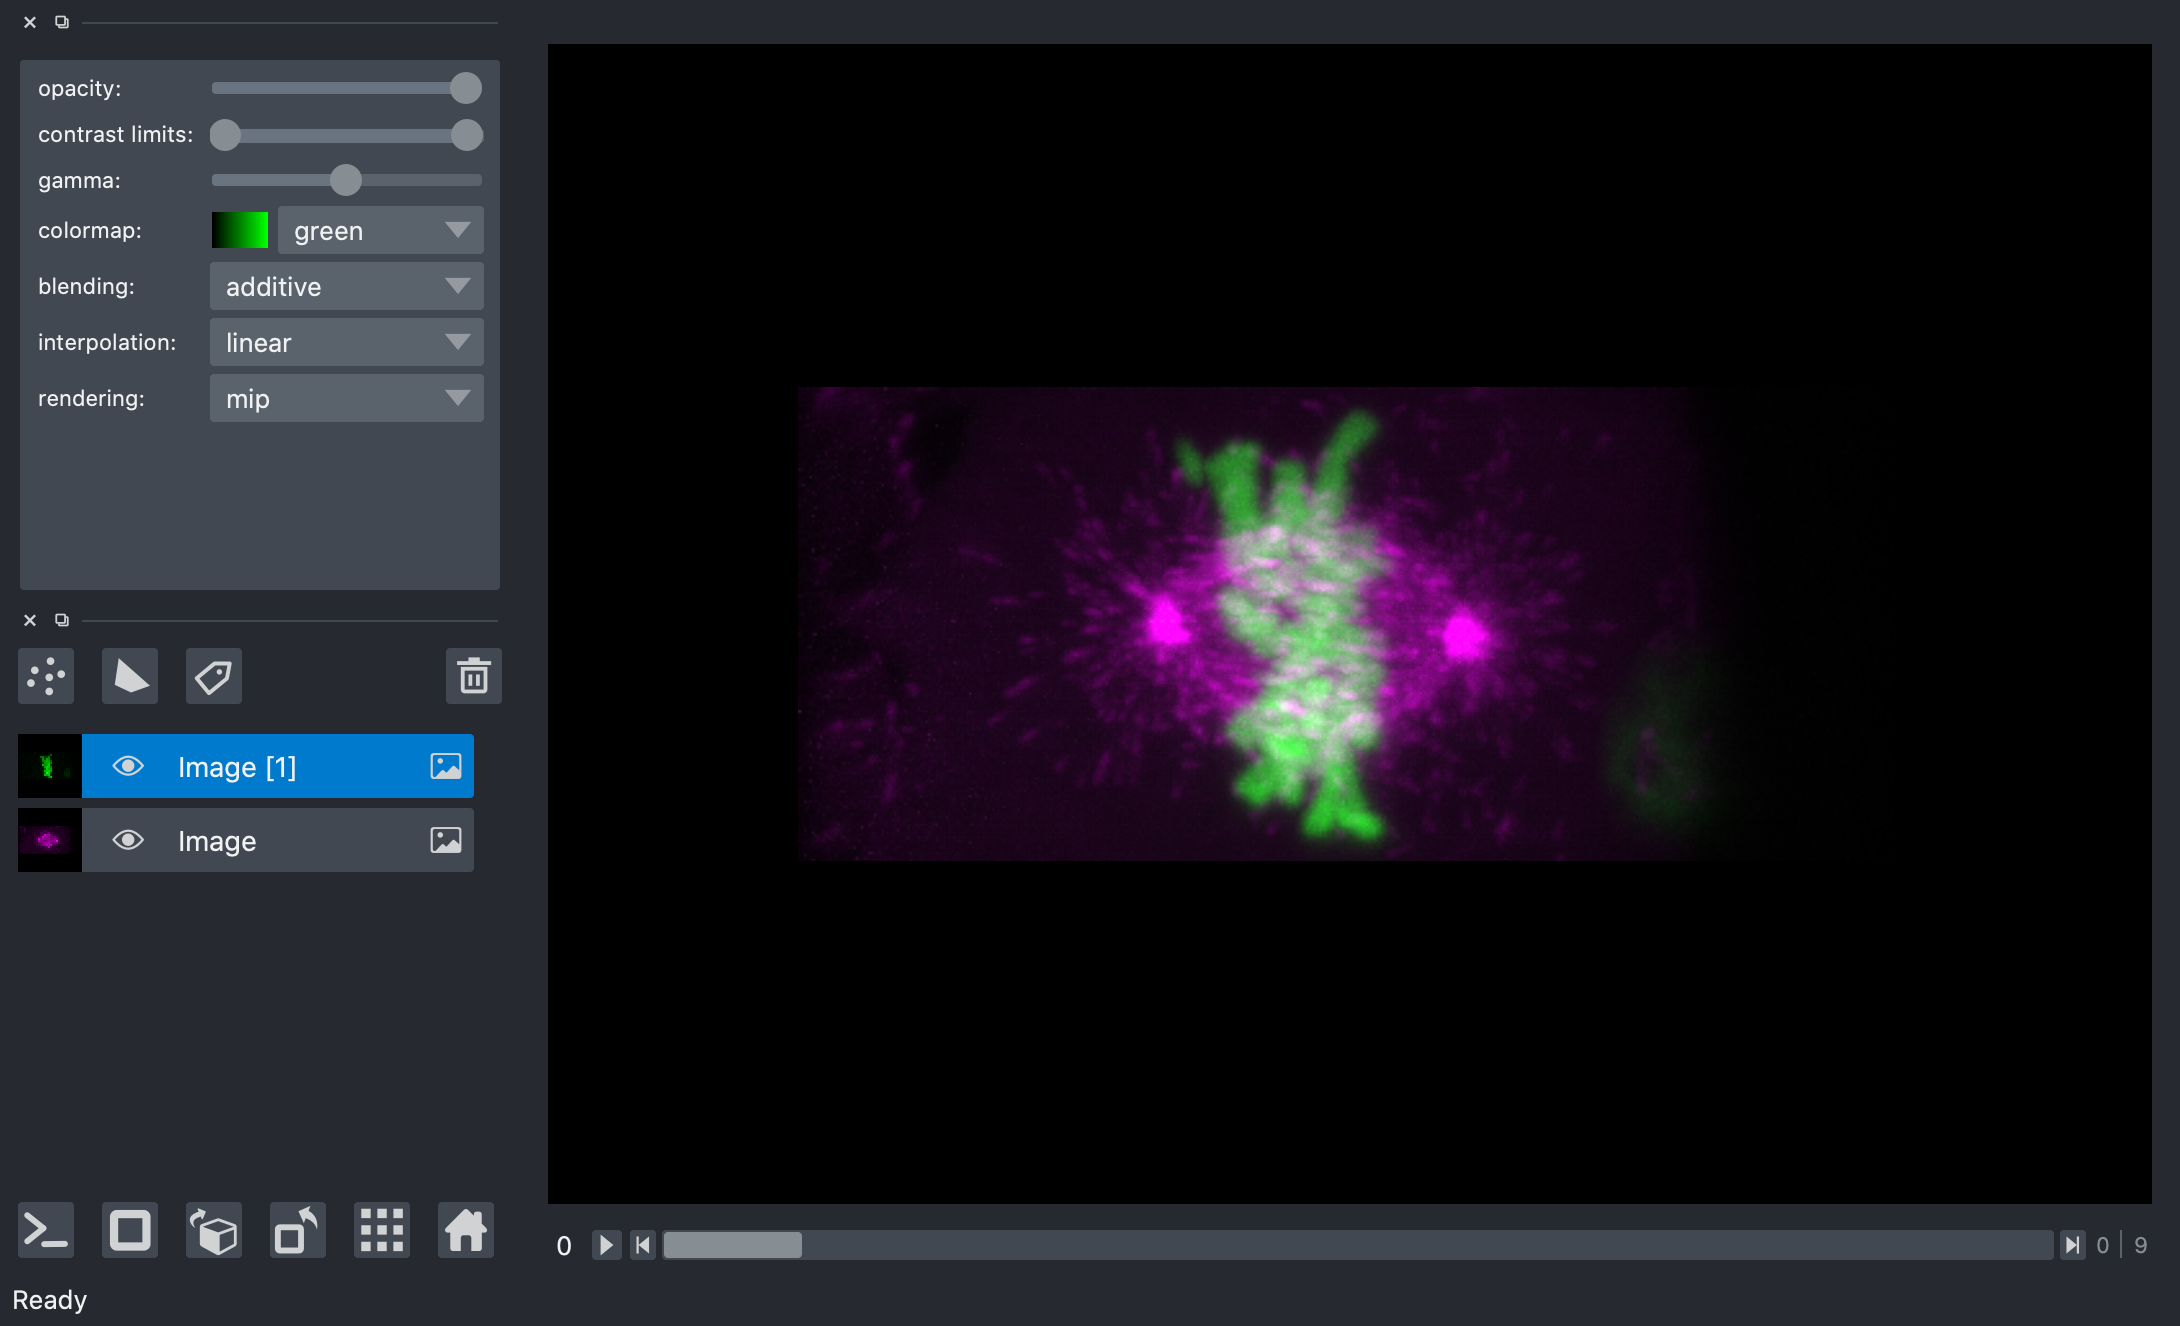

In [8]:
deskewed_reshaped = deskewed.reshape(2,-1,*new_shape)

viewer = view_image(deskewed_reshaped,
                    channel_axis=0,
                    scale=(1,dzdx_ratio,1,1),
                    contrast_limits=(100, 1200))
viewer.dims.ndisplay = 3

utils.nbscreenshot(viewer)

## napari plugins

Got a useful `path -> [dask|numpy].array`  pattern?

Share it as a plugin!

```python
# my_plugin.py
from napari_plugin_engine import napari_hook_implementation

@napari_hook_implementation
def get_napar_reader(path):
    if path_is_supported(path):
        return func_that_takes_path_and_returns_array
```


```ini
# setup.cfg
[metadata]
classifiers =
    Framework :: napari

[options.entry_points] 
napari.plugin = 
    plugin_name = my_plugin 
```

#### more info on making a napari plugin:

https://napari.org/plugins/stable/for_plugin_developers.html

#### example plugin implementing the dask-based pipeline above:

https://github.com/tlambert03/napari-ndtiffs